<a href="https://colab.research.google.com/github/ashish244co/SHALA2020/blob/master/Ashish_Kashav_assignment_segmentation_SHALA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download CamVid Dataset

Code in below cell downloads subset of CamVid dataset with 12 classes. Run the cell and download the data. Class names(12 in number) and 12 distinct RGB values for different colours is also given.

- Print total number of train, val and test images available in dataset
- Visualize any random image and corrosponding mask with the use of CLASS_NAMES and CLASS_COLORS
- All the images are of same size. Print size of image.

In [1]:
import os

DATA_DIR = './data/CamVid/'

if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')
    
CLASS_NAMES = ['sky', 'building', 'pole', 'road', 'pavement',
               'tree', 'signsymbol', 'fence', 'car',
               'pedestrian', 'bicyclist', 'unlabelled']

CLASS_COLORS = [(128, 128, 128), (128, 0, 0), (192, 192, 128), (128, 64, 128), (0, 0, 192),
                (128, 128, 0), (192, 128, 128), (64, 64, 128), (64, 0, 128),
                (64, 64, 0), (0, 128, 192), (0, 0, 0)]

Loading data...
Done!


In [2]:
!pip install -U catalyst

     |████████████████████████████████| 368kB 5.8MB/s 
     |████████████████████████████████| 204kB 13.5MB/s 
     |████████████████████████████████| 460kB 12.0MB/s 
     |████████████████████████████████| 71kB 7.5MB/s 


In [0]:
import os
from collections import OrderedDict
from functools import partial
import numpy as np
import torch
import torch.nn as nn
import cv2
from torch.optim import Adam, SGD, ASGD, RMSprop, LBFGS
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.models import resnet34
from datetime import datetime

In [0]:
import torchvision

In [5]:
! pip install --quiet git+https://github.com/albu/albumentations

     |████████████████████████████████| 634kB 6.2MB/s 


In [0]:
import albumentations as A

In [0]:
class CamVidDataset(Dataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (A.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
    """

    def __init__(
            self,
            images_dir,
            masks_dir,
            transform=A.Normalize()
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        self.transform = transform


    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.images_fps[i])
        mask = cv2.imread(self.masks_fps[i],cv2.IMREAD_GRAYSCALE)
        
        # apply augmentations

        

        sample = self.transform(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']
        image = np.moveaxis(image, -1, 0)
        image = np.ascontiguousarray(image)
        image = torch.from_numpy(image)

        return {
            "features": image,
            "targets": torch.from_numpy(mask).long()
        }

    def __len__(self):
        return len(self.ids)

In [0]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [0]:
def get_training_augmentation(blur=True, weather=True):
    return A.Compose([
        A.PadIfNeeded(384, 384, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=11),
        A.Normalize()
    ])


def get_validation_augmentation():
    return A.Compose([
        A.PadIfNeeded(384, 384, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=11),
        A.Normalize()
    ])

In [11]:
train_ds = CamVidDataset(x_train_dir, y_train_dir, transform=get_training_augmentation())
valid_ds = CamVidDataset(x_valid_dir, y_valid_dir, transform=get_validation_augmentation())

print('Train dataset size', len(train_ds))
print('Valid dataset size', len(valid_ds))

Train dataset size 367
Valid dataset size 101


In [0]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


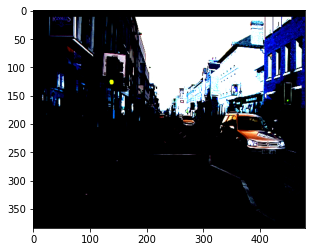

In [13]:
plt.imshow(np.transpose(train_ds[1]['features'].cpu().detach().numpy(), (1, 2, 0)))

In [14]:
np.transpose(train_ds[1]['features'].cpu().detach().numpy(), (1, 2, 0)).shape

(384, 480, 3)

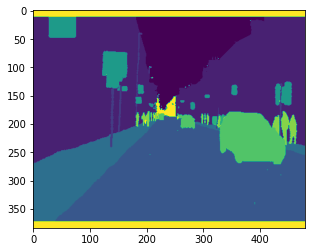

In [15]:
plt.imshow(train_ds[1]['targets'])

In [0]:
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor, smooth=0, eps=1e-7, dims=None) -> torch.Tensor:
   
    if dims is not None:
        intersection = torch.sum(y_pred * y_true, dim=dims)
        cardinality = torch.sum(y_pred + y_true, dim=dims)
    else:
        intersection = torch.sum(y_pred * y_true)
        cardinality = torch.sum(y_pred + y_true)
    dice_score = (2.0 * intersection) / (cardinality+ eps)
    return dice_score

In [66]:
A.PadIfNeeded(384, 384, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=11)

TypeError: ignored

In [0]:
(360, 480, 3)

In [0]:
class DecoderBlockLinkNet(nn.Module):
    def __init__(self, in_channels, n_filters):
        super().__init__()

        self.relu = nn.ReLU(inplace=True)

        # B, C, H, W -> B, C/4, H, W
        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
        self.norm1 = nn.BatchNorm2d(in_channels // 4)

        # B, C/4, H, W -> B, C/4, 2 * H, 2 * W
        self.deconv2 = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,
                                          stride=2, padding=1, output_padding=0)
        self.norm2 = nn.BatchNorm2d(in_channels // 4)

        # B, C/4, H, W -> B, C, H, W
        self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
        self.norm3 = nn.BatchNorm2d(n_filters)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.deconv2(x)
        x = self.norm2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu(x)
        return x


class LinkNet34(nn.Module):
    def __init__(self, num_classes=1, num_channels=3, pretrained=True):
        super().__init__()
        assert num_channels == 3
        self.num_classes = num_classes
        filters = [64, 128, 256, 512]
        resnet = resnet34(pretrained=pretrained)

        self.firstconv = resnet.conv1
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.firstmaxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        # Decoder
        self.decoder4 = DecoderBlockLinkNet(filters[3], filters[2])
        self.decoder3 = DecoderBlockLinkNet(filters[2], filters[1])
        self.decoder2 = DecoderBlockLinkNet(filters[1], filters[0])
        self.decoder1 = DecoderBlockLinkNet(filters[0], filters[0])

        # Final Classifier
        self.finaldeconv1 = nn.ConvTranspose2d(filters[0], 32, 3, stride=2)
        self.finalrelu1 = nn.ReLU(inplace=True)
        self.finalconv2 = nn.Conv2d(32, 32, 3)
        self.finalrelu2 = nn.ReLU(inplace=True)
        self.finalconv3 = nn.Conv2d(32, num_classes, 2, padding=1)

    def forward(self, x):
      
        # Encoder
        x = self.firstconv(x)
        x = self.firstbn(x)
        x = self.firstrelu(x)
        x = self.firstmaxpool(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        print(e3.size())
        # Decoder with Skip Connections
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)

        # Final Classification
        f1 = self.finaldeconv1(d1)
        f2 = self.finalrelu1(f1)
        f3 = self.finalconv2(f2)
        f4 = self.finalrelu2(f3)
        f5 = self.finalconv3(f4)
        
        return f5 

In [0]:
num_classes = len(CLASS_NAMES)

In [39]:
num_classes

12

In [18]:
net=LinkNet34(num_classes).cuda()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings("ignore")

In [0]:
loss_fn = nn.CrossEntropyLoss()
opt = Adam(net.parameters(),weight_decay=1e-3)

In [0]:
data_loaders = {}
data_loaders['train'] = DataLoader(train_ds, batch_size=16, pin_memory=True)
data_loaders['valid'] = DataLoader(valid_ds, batch_size=16, pin_memory=True)

In [0]:
dataloader_iterator = iter(data_loaders['train'])

In [23]:
next(dataloader_iterator)['features'].shape[0]

16

In [24]:
from catalyst.dl import SupervisedRunner

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



In [26]:
runner = SupervisedRunner()
runner.train(
    model=net,
    criterion=loss_fn,
    optimizer=opt,
    loaders=data_loaders,
    num_epochs=5,
    verbose=True
)


1/5 * Epoch (train):   0% 0/23 [00:00<?, ?it/s]torch.Size([16, 256, 24, 30])
torch.Size([16, 256, 24, 30])

1/5 * Epoch (train):   0% 0/23 [00:01<?, ?it/s, loss=2.485]
1/5 * Epoch (train):   4% 1/23 [00:01<00:36,  1.64s/it, loss=2.485]torch.Size([16, 256, 24, 30])
torch.Size([16, 256, 24, 30])

1/5 * Epoch (train):   4% 1/23 [00:03<00:36,  1.64s/it, loss=2.456]
1/5 * Epoch (train):   9% 2/23 [00:03<00:33,  1.60s/it, loss=2.456]torch.Size([16, 256, 24, 30])
torch.Size([16, 256, 24, 30])

1/5 * Epoch (train):   9% 2/23 [00:04<00:33,  1.60s/it, loss=2.423]
1/5 * Epoch (train):  13% 3/23 [00:04<00:31,  1.57s/it, loss=2.423]torch.Size([16, 256, 24, 30])
torch.Size([16, 256, 24, 30])

1/5 * Epoch (train):  13% 3/23 [00:06<00:31,  1.57s/it, loss=2.387]
1/5 * Epoch (train):  17% 4/23 [00:06<00:29,  1.54s/it, loss=2.387]torch.Size([16, 256, 24, 30])
torch.Size([16, 256, 24, 30])

1/5 * Epoch (train):  17% 4/23 [00:07<00:29,  1.54s/it, loss=2.334]
1/5 * Epoch (train):  22% 5/23 [00:07<00:27,  1